## Weight of Evidence & Information Value

Weight of evidence (WOE) и Information value (IV) простые, но сильные техники для трансформирования и отбора признаков. Этот концепт хорошо зарекомендовал себя в логистической регрессии, широко используется в задачах кредитного скоринга.

Идея - применять техники для отбора признаков. Когда алгоритм выбирает признак, происходит голосование за этот признак. В конце считается общее количество голосов за каждый признак и выбираются лучшие.


Преимущества WOE:
1. Обработка пропущенных значений
2. Обработка выбросов

Шаги подсчета WOE:
1. Для вещественных признаков разделить данные на определенное количество групп (10 или меньше).
2. Подсчитать количество положительного и отрицательного классов в каждой группе.
3. Подсчитать процент положительного и отрицательно классов в каждой группе.
4. Подсчитать WOE по формуле:
$$WOE = \ln(\frac{n_+}{n_-}) - \ln(\frac{N_+}{N_-}) = \ln(\frac{\frac{n_+}{N_+}}{\frac{n_-}{N_-}}) = \ln(\frac{\text{event}}{\text{not event}}),$$
где n - количество объектов в группе, N - общее количество

Для категориальных признаков нет нужды выполнять 1 шаг.

$$IV = \sum_{i=1}^l((\text{event}_i - \text{not event}_i)WOE_i)$$

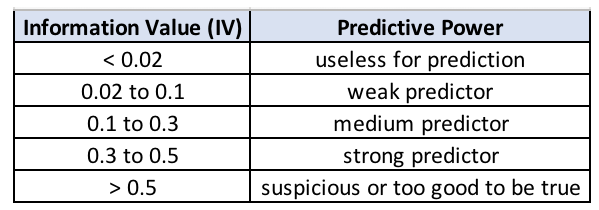

[Статья](https://sundarstyles89.medium.com/weight-of-evidence-and-information-value-using-python-6f05072e83eb) про WOE и IV.

In [1]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

In [2]:
X, y = make_classification(n_samples=10000, weights=[0.7, 0.3], n_informative=5, n_features=10,
                           n_redundant=5, random_state=1)
X = pd.DataFrame(X)
y = pd.Series(y, name='target')
y.value_counts()

0    6982
1    3018
Name: target, dtype: int64

In [3]:
df = pd.concat([X, y], axis=1)
target = 'target'

In [4]:
small_X_0 = X.loc[:, :0]

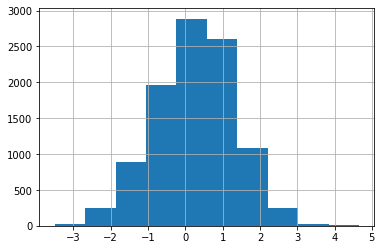

In [5]:
small_X_0[0].hist();

[Статья](https://towardsdatascience.com/introducing-xverse-a-python-package-for-feature-selection-and-transformation-17193cdcd067) про Xverse.

[Документация](https://pypi.org/project/xverse/) про Xverse.

In [ ]:
# !pip install xverse==1.0.3

**Шаг 1. Разбить данные на бины**

In [6]:
from xverse.transformer import MonotonicBinning

clf = MonotonicBinning(prefix='bin')
small_X_binned = clf.fit_transform(small_X_0, y)

clf.bins

{'0': array([-3.5031007 , -0.17817124,  0.74711179,  4.65649501])}

In [7]:
small_X_binned

,0,bin_0
0,1.443879,"(0.747, 4.656]"
1,1.599450,"(0.747, 4.656]"
2,1.759104,"(0.747, 4.656]"
3,-0.868418,"(-3.504, -0.178]"
4,0.500644,"(-0.178, 0.747]"
...,...,...
9995,0.425595,"(-0.178, 0.747]"
9996,0.012824,"(-0.178, 0.747]"
9997,0.405631,"(-0.178, 0.747]"
9998,0.506653,"(-0.178, 0.747]"


**Или это всё можно сделать в классе WOE**

In [8]:
from xverse.transformer import WOE

clf = WOE()
clf.fit(small_X_0, y)

WOE(mono_custom_binning={'0': array([-3.5031007 , -0.17817124,  0.74711179,  4.65649501])},
    woe_bins={'0': {Interval(-3.504, -0.178, closed='right'): 1.0325063919914435,
                    Interval(-0.178, 0.747, closed='right'): -0.3121627878585204,
                    Interval(0.747, 4.656, closed='right'): -1.1852040878931334}})

In [9]:
clf.woe_df # weight of evidence transformation dataset.

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
0,0,"(-3.504, -0.178]",3334,1828,1506,0.548290,0.451710,0.605699,0.215698,1.032506,0.780017
1,0,"(-0.178, 0.747]",3333,801,2532,0.240324,0.759676,0.265408,0.362647,-0.312163,0.780017
2,0,"(0.747, 4.656]",3333,389,2944,0.116712,0.883288,0.128893,0.421656,-1.185204,0.780017


In [10]:
# Event_Rate
1828 / 3334, 801 / 3333, 389 / 3333

(0.5482903419316136, 0.24032403240324032, 0.11671167116711671)

In [11]:
clf.woe_df[['Event', 'Non_Event']].sum()

Event        3018
Non_Event    6982
dtype: int64

In [12]:
# Event_Distribution
1828 / 3018, 801 / 3018, 389 / 3018

(0.6056991385023194, 0.2654075546719682, 0.1288933068257124)

$$WOE = \ln(\frac{\text{event}}{\text{not event}})$$

In [13]:
# WOE
np.log([0.605699 / 0.215698,
        0.265408 / 0.362647,
        0.128893 / 0.421656])

array([ 1.03250388, -0.31216164, -1.18520721])

$$IV = \sum{(\text{event} - \text{not event})\ln(\frac{\text{event}}{\text{not event}})}$$

In [14]:
# IV
sum([(0.605699 - 0.215698) * 1.03250388, 
     (0.265408 - 0.362647) * -0.31216164,
     (0.128893 - 0.421656) * -1.18520721])

0.78001664983707

**Посмотрим корреляцию, чтобы обнаружить потенциально бесполезные признаки**

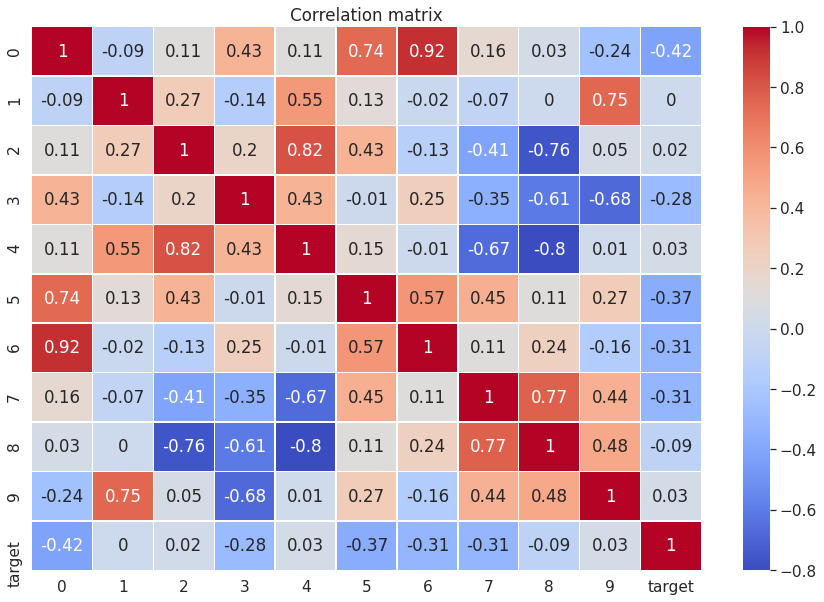

In [15]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.0] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**Посчитаем WOE&IV для признака с наименьшей корреляцией**

In [16]:
small_X_1 = X.loc[:, 1:1]

In [17]:
from xverse.transformer import WOE

clf_2 = WOE()
clf_2.fit(small_X_1, y)

WOE(mono_custom_binning={'1': array([-4.25466516,  0.43889699,  1.56689588,  7.35071304])},
    woe_bins={'1': {Interval(-4.256, 0.439, closed='right'): -0.1169365234453452,
                    Interval(0.439, 1.567, closed='right'): 0.18982712275406743,
                    Interval(1.567, 7.351, closed='right'): -0.08385885273023255}})

In [18]:
clf_2.woe_df

,Variable_Name,Category,Count,Event,Non_Event,Event_Rate,Non_Event_Rate,Event_Distribution,Non_Event_Distribution,WOE,Information_Value
0,1,"(-4.256, 0.439]",3334,926,2408,0.277744,0.722256,0.306826,0.344887,-0.116937,0.019196
1,1,"(0.439, 1.567]",3333,1144,2189,0.343234,0.656766,0.379059,0.313520,0.189827,0.019196
2,1,"(1.567, 7.351]",3333,948,2385,0.284428,0.715572,0.314115,0.341593,-0.083859,0.019196


**Обучим модель и проверим её качество**

In [19]:
clf = WOE()
clf.fit(X, y);

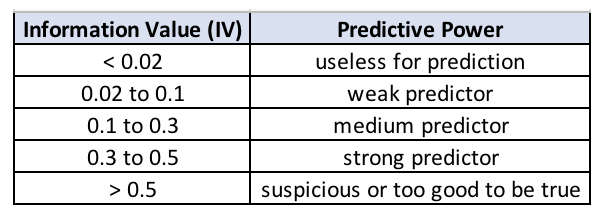

In [20]:
clf.iv_df

,Variable_Name,Information_Value
5,5,0.892250
0,0,0.780017
7,7,0.483295
6,6,0.368368
3,3,0.324163
9,9,0.066956
8,8,0.065930
1,1,0.019196
4,4,0.014839
2,2,0.010449


**Feature Selection**

In [30]:
# ничего не удаляем, обучаемся на всех данных
drop_cols = []

# удаляем признаки с маленьким IV
drop_cols = [1, 4, 2]

# удаляем признаки с слишком большим IV
drop_cols = [0, 5] + drop_cols

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=drop_cols),
                                                    y, test_size=0.2, random_state=2,
                                                    stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.69825
1    0.30175
Name: target, dtype: float64

0    0.698
1    0.302
Name: target, dtype: float64

In [32]:
tree = LogisticRegressionCV(random_state=2)
tree.fit(X_train, y_train)

pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

print(f'F1-мера на первом классе на трейне {round(f1_score(y_train, pred_train), 2)}')
print(f'F1-мера на первом классе на тесте {round(f1_score(y_test, pred_test), 2)}')

F1-мера на первом классе на трейне 0.68
F1-мера на первом классе на тесте 0.69


Заменить признаки на WOE трансформированные

In [33]:
X.columns = [str(i) for i in range(10)]
X

,0,1,2,3,4,5,6,7,8,9
0,1.443879,-2.290785,-3.787321,-0.927797,-5.682765,0.149896,3.093902,0.980390,5.363332,-1.399472
1,1.599450,2.786643,1.179546,-0.235365,2.244515,3.889261,2.063918,1.733783,2.042197,2.672536
2,1.759104,0.462664,-0.883933,3.466748,1.360786,0.575399,2.325615,-0.096875,-0.621695,-1.305655
3,-0.868418,2.268825,-2.355559,-1.352118,0.019916,-2.632455,0.303704,-1.056388,2.798742,1.535317
4,0.500644,1.225395,1.305498,0.176004,2.753477,0.831176,0.826183,-0.993737,-1.298216,0.502521
...,...,...,...,...,...,...,...,...,...,...
9995,0.425595,0.553386,1.941335,-0.738567,1.993713,1.666599,0.479312,-0.468460,-1.111326,0.659814
9996,0.012824,1.288255,0.266218,-0.868714,1.808897,-0.393777,0.788826,-1.488981,-0.070072,0.696636
9997,0.405631,0.734685,-0.447460,0.504447,0.492287,0.123730,0.751595,0.023432,0.544484,0.242788
9998,0.506653,0.155234,1.218075,1.052330,3.388103,-0.717811,1.150337,-3.028804,-3.464261,-1.364550


In [46]:
clf = WOE(mono_force_bins=10)
clf.fit(X, y);

In [47]:
X_woe = clf.transform(X, y)
clf.iv_df

,Variable_Name,Information_Value
5,5,1.127078
0,0,0.945015
6,6,0.689965
3,3,0.564377
7,7,0.555505
8,8,0.248383
9,9,0.178018
2,2,0.067831
1,1,0.042589
4,4,0.023501


In [48]:
X_woe['5'].unique()

array([ 0.17989999, -3.21865473, -0.24923284,  0.83874105, -0.67760644,
       -1.20191447,  0.93882451, -1.63109535,  1.14921114,  0.56911947])

In [49]:
X_woe.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')

In [56]:
# ничего не удаляем, обучаемся на всех данных
drop_cols = []

# удаляем признаки с маленьким IV
# drop_cols = ['1', '4', '2']

# удаляем признаки с слишком большим IV
# drop_cols = ['5']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_woe.drop(columns=drop_cols),
                                                    y, test_size=0.2, random_state=2, stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.69825
1    0.30175
Name: target, dtype: float64

0    0.698
1    0.302
Name: target, dtype: float64

In [58]:
tree = LogisticRegressionCV(random_state=2)
tree.fit(X_train, y_train)

pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

print(f'F1-мера на первом классе на трейне {round(f1_score(y_train, pred_train), 2)}')
print(f'F1-мера на первом классе на тесте {round(f1_score(y_test, pred_test), 2)}')

F1-мера на первом классе на трейне 0.68
F1-мера на первом классе на тесте 0.68


## Балансировка данных

**Способы борьбы с дисбалансом классов**

1. Собрать больше данных
2. Выбрать подходящую метрику качества
3. Попробовать разные модели, одни модели более устойчивы к несбалансированным данным, чем другие
4. Штраф за ошибки при прогнозе меньшего класса
5. Undersampling и Oversampling

https://habr.com/ru/post/461285/
<img src="images/balancing.png">
Undersampling с использованием Tomek Links:
<img src="images/tomek.png">
Oversampling со SMOTE:
<img src="images/smote.png">

In [59]:
df[target].value_counts()

0    6982
1    3018
Name: target, dtype: int64

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.69825
1    0.30175
Name: target, dtype: float64

0    0.698
1    0.302
Name: target, dtype: float64

In [61]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.3140016570008286

In [62]:
lr = LogisticRegressionCV()
lr.fit(X_train, y_train)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

print(f'F1-мера на первом классе на трейне {round(f1_score(y_train, pred_train), 2)}')
print(f'F1-мера на первом классе на тесте {round(f1_score(y_test, pred_test), 2)}')

F1-мера на первом классе на трейне 0.68
F1-мера на первом классе на тесте 0.69


In [63]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

_Oversampling_

In [64]:
train_df = pd.concat([pd.DataFrame(X_train), y_train], axis=1)
print(f'До oversampling:\n{y_train.value_counts()}')
over_df = balance_df_by_target(train_df, target_name=target, method='over')
print(f'\nПосле oversampling:\n{over_df[target].value_counts()}')

До oversampling:
0    5586
1    2414
Name: target, dtype: int64

После oversampling:
0    5586
1    4828
Name: target, dtype: int64


In [65]:
lr = LogisticRegressionCV()
lr.fit(over_df.drop(columns=target), over_df[target])

pred_train = lr.predict(over_df.drop(columns=target))
pred_test = lr.predict(X_test)

print(f'F1-мера на первом классе на трейне {round(f1_score(over_df[target], pred_train), 2)}')
print(f'F1-мера на первом классе на тесте {round(f1_score(y_test, pred_test), 2)}')

F1-мера на первом классе на трейне 0.85
F1-мера на первом классе на тесте 0.77


_Undersampling_

In [66]:
print(f'До undersampling:\n{train_df[target].value_counts()}')
under_df = balance_df_by_target(train_df, target_name=target, method='under')
print(f'\nПосле undersampling:\n{under_df[target].value_counts()}')

До undersampling:
0    5586
1    2414
Name: target, dtype: int64

После undersampling:
1    2414
0    2414
Name: target, dtype: int64


In [67]:
lr = LogisticRegressionCV()
lr.fit(under_df.drop(columns=target), under_df[target])

pred_train = lr.predict(under_df.drop(columns=target))
pred_test = lr.predict(X_test)

print(f'F1-мера на первом классе на трейне {round(f1_score(under_df[target], pred_train), 2)}')
print(f'F1-мера на первом классе на тесте {round(f1_score(y_test, pred_test), 2)}')

F1-мера на первом классе на трейне 0.87
F1-мера на первом классе на тесте 0.78


_Undersampling (TomekLinks)_ 

In [68]:
print(f'До undersampling:\n{train_df[target].value_counts()}')
under_df = balance_df_by_target(train_df, target_name=target, method='tomek')
print(f'\nПосле undersampling:\n{under_df[target].value_counts()}')

До undersampling:
0    5586
1    2414
Name: target, dtype: int64

После undersampling:
0    5462
1    2414
Name: target, dtype: int64


In [69]:
lr = LogisticRegressionCV()
lr.fit(under_df.drop(columns=target), under_df[target])

pred_train = lr.predict(under_df.drop(columns=target))
pred_test = lr.predict(X_test)

print(f'F1-мера на первом классе на трейне {round(f1_score(under_df[target], pred_train), 2)}')
print(f'F1-мера на первом классе на тесте {round(f1_score(y_test, pred_test), 2)}')

F1-мера на первом классе на трейне 0.7
F1-мера на первом классе на тесте 0.7


_Oversampling (SMOTE)_

In [72]:
print(f'До undersampling:\n{train_df[target].value_counts()}')
over_df = balance_df_by_target(train_df, target_name=target, method='smote')
print(f'\nПосле oversampling:\n{over_df[target].value_counts()}')

До undersampling:
0    5586
1    2414
Name: target, dtype: int64

После oversampling:
1    5586
0    5586
Name: target, dtype: int64


In [71]:
lr = LogisticRegressionCV()
lr.fit(over_df.drop(columns=target), over_df[target])

pred_train = lr.predict(over_df.drop(columns=target))
pred_test = lr.predict(X_test)

print(f'F1-мера на первом классе на трейне {round(f1_score(over_df[target], pred_train), 2)}')
print(f'F1-мера на первом классе на тесте {round(f1_score(y_test, pred_test), 2)}')

F1-мера на первом классе на трейне 0.87
F1-мера на первом классе на тесте 0.78


_Балансировка через атрибуты моделей (веса классов)_

In [73]:
disbalance

2.3140016570008286

In [75]:
lr = LogisticRegressionCV(
#                             class_weight={0: 1, 1: disbalance},
                            class_weight="balanced"
                            )
lr.fit(X_train, y_train)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

print(f'F1-мера на первом классе на трейне {round(f1_score(y_train, pred_train), 2)}')
print(f'F1-мера на первом классе на тесте {round(f1_score(y_test, pred_test), 2)}')

F1-мера на первом классе на трейне 0.77
F1-мера на первом классе на тесте 0.78
